In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np

from engine.utils import get_config
from engine.train import train
from engine.eval import eval
from engine.show import show

%matplotlib inline

In [4]:
"""
Just for jupyter notebook
"""
import os
import argparse
from argparse import ArgumentParser
from config import cfg

def get_config():
    parser = ArgumentParser()
    parser.add_argument(
        '--task',
        type=str,
        default='train',
        metavar='TASK',
        help='What to do. See engine'
    )
    parser.add_argument(
        '--config-file',
        type=str,
        default='',
        metavar='FILE',
        help='Path to config file'
    )
    
    parser.add_argument(
        'opts',
        help='Modify config options using the command line',
        default=None,
        nargs=argparse.REMAINDER
    )
    args = parser.parse_args('')
    
    args.task = "eval"
    args.config_file = "configs/atari_joint.yaml"
    args.opts = ['resume', True, 'resume_ckpt', '../pretrained/atari_joint.pth', 'device', 'cpu']
    
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    if args.opts:
        cfg.merge_from_list(args.opts)
    
    # Use config file name as the default experiment name
    if cfg.exp_name == '':
        if args.config_file:
            cfg.exp_name = os.path.splitext(os.path.basename(args.config_file))[0]
        else:
            raise ValueError('exp_name cannot be empty without specifying a config file')
        
    # Seed
    import torch
    torch.manual_seed(cfg.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import numpy as np
    np.random.seed(cfg.seed)
    
    return cfg, args.task


cfg, task = get_config()

In [5]:
from model import get_model
from vis import get_vislogger
from dataset import get_dataset, get_dataloader
from utils import Checkpointer
import os
import os.path as osp
from torch import nn
from torch.utils.data import Subset, DataLoader

BATCH_SIZE=1

In [26]:
model = get_model(cfg)
model = model.to(cfg.device)
model.eval()
checkpointer = Checkpointer(osp.join(cfg.checkpointdir, cfg.exp_name), max_num=cfg.train.max_ckpt)
use_cpu = 'cpu' in cfg.device
if cfg.resume_ckpt:
    checkpoint = checkpointer.load(cfg.resume_ckpt, model, None, None, use_cpu=use_cpu)

dataset = get_dataset(cfg, cfg.show.mode)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

Loading checkpoint from ../pretrained/atari_spaceinvaders.pth...
Checkpoint loaded.


In [27]:
# for i, imgs in enumerate(dataloader):
imgs = next(iter(dataloader))
imgs = imgs.to(cfg.device)

In [28]:
# TODO: treat global_step in a more elegant way
loss, log = model(imgs, global_step=100000000)

In [28]:
print(log.keys())

dict_keys(['imgs', 'y', 'mse', 'log_like', 'fg', 'z_what', 'z_where', 'z_pres', 'z_scale', 'z_shift', 'z_depth', 'z_pres_prob', 'prior_z_pres_prob', 'o_att', 'alpha_att_hat', 'alpha_att', 'alpha_map', 'boundary_loss', 'boundary_map', 'importance_map_full_res_norm', 'kl_z_what', 'kl_z_pres', 'kl_z_scale', 'kl_z_shift', 'kl_z_depth', 'kl_z_where', 'comps', 'masks', 'bg', 'kl_bg'])


In [32]:
# (B, N, 4), (B, N, 1), (B, N, D)
z_where, z_pres_prob, z_what = log['z_where'], log['z_pres_prob'], log['z_what']
# (B, N, 4), (B, N), (B, N)
z_where = z_where.detach().cpu()

z_pres_prob = z_pres_prob.detach().cpu().squeeze()
# TODO: look at this
z_pres = z_pres_prob > 0.5

z_what_pres = z_what[z_pres.unsqueeze(0)]

In [ ]:
# How to concert the z_where to true x, y positions (here in bounding boxes)
# see convert_to_boxes for more info:
# boxes_batch = convert_to_boxes(z_where, z_pres, z_pres_prob)

from .ap import read_boxes, convert_to_boxes, compute_ap, compute_counts

boxes_batch = convert_to_boxes(z_where, z_pres, z_pres_prob)

# each (B, N, 1)
# width, height, center_x, center_y = torch.split(z_where, 1, dim=-1)
# center_x = (center_x + 1.0) / 2.0
# center_y = (center_y + 1.0) / 2.0
# x_min = center_x - width / 2
# x_max = center_x + width / 2
# y_min = center_y - height / 2
# y_max = center_y + height / 2

# # (B, N, 4)
# pos = torch.cat([y_min, y_max, x_min, x_max], dim=-1)

### TSNE

In [33]:
from sklearn.manifold import TSNE
z_what_pres_emb = TSNE(n_components=2).fit_transform(z_what_pres.detach().cpu().numpy())

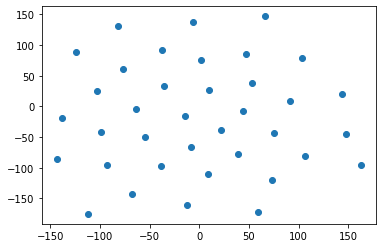

In [34]:
fig, ax = plt.subplots(1, 1)
ax.scatter(z_what_pres_emb[:, 0], z_what_pres_emb[:, 1])
plt.show()

### PCA

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_what_pres_emb = pca.fit_transform(z_what_pres.detach().cpu().numpy())

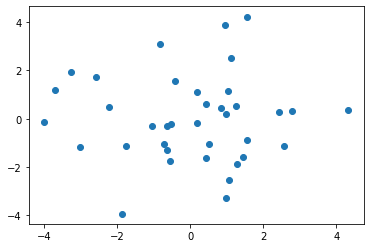

In [36]:
fig, ax = plt.subplots(1, 1)
ax.scatter(z_what_pres_emb[:, 0], z_what_pres_emb[:, 1])
plt.show()

### Input Images

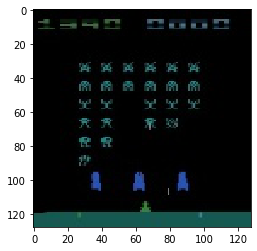

In [37]:
fig, ax = plt.subplots(1, 1)
ax.imshow(np.moveaxis(imgs[0].detach().cpu().numpy(), (0, 1, 2), (2, 0, 1)))
plt.show()

# fig, ax = plt.subplots(1, 1)
# ax.imshow(np.moveaxis(imgs[1].detach().cpu().numpy(), (0, 1, 2), (2, 0, 1)))
# plt.show()

# fig, ax = plt.subplots(1, 1)
# ax.imshow(np.moveaxis(imgs[2].detach().cpu().numpy(), (0, 1, 2), (2, 0, 1)))
# plt.show()

# fig, ax = plt.subplots(1, 1)
# ax.imshow(np.moveaxis(imgs[3].detach().cpu().numpy(), (0, 1, 2), (2, 0, 1)))
# plt.show()

# fig, ax = plt.subplots(1, 1)
# ax.imshow(np.moveaxis(imgs[4].detach().cpu().numpy(), (0, 1, 2), (2, 0, 1)))
# plt.show()

### Pairwise Distances

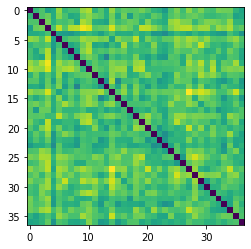

In [39]:
from sklearn.metrics.pairwise import euclidean_distances
X = z_what_pres.detach().cpu().numpy()
dist_mat = euclidean_distances(X, X)

fig, ax  = plt.subplots(1, 1)
ax.imshow(dist_mat)
plt.show()